In [92]:
# import libraries
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np 
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.ops import MLP
from torch import nn, optim
import cv2
from tqdm import tqdm

from sklearn.metrics import classification_report

from network import Network
from vgg16modified import Network as MVGG16Net
from utils import device, get_all_preds, get_num_correct

In [93]:
path_model = 'models/checkpoint-vgg-last2.pth'
path_visu = 'visualizations/vgg-last2_tests.png'
path_conf = 'visualizations/vgg-last2_conf.png'

In [94]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('OK CUDA was avaialbe.')
else:
    device = torch.device('cpu')
print(device)

cpu


## results for transfer learning with VGG-16
- first 8 layers were freezed and the classifier was replaced with 3 FC layers, then the model was trained.

In [95]:
# convertes to tensor and normalizes the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
])
train_set = torchvision.datasets.CIFAR10(
    root='./ds/train',
    train=True,
    download=True,
    transform=transform
)
test_set = torchvision.datasets.CIFAR10(
    root='./ds/test',
    train=False,
    download=True,
    transform=transform
)
# load the train set and test set
train_loader = torch.utils.data.DataLoader(train_set, batch_size=500, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [96]:
model = MVGG16Net(torchvision.models.vgg16(pretrained=False))
model.load_state_dict(
    torch.load(path_model,
    map_location=device)
)
model.to(device)
model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Network(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [97]:
# set model to eval mode and turn off gradient tracking as well
model.eval()
with torch.no_grad():
    # train preds
    bcount = 0
    train_preds = torch.tensor([])
    for batch in train_loader:
        images = batch[0].to(device)
        preds = model(images)

        train_preds = torch.cat((train_preds, preds), dim=0)

        bcount += 1
        print(f'{bcount} of train')

    # test preds
    bcount = 0
    test_preds = torch.tensor([])
    for batch in test_loader:
        images = batch[0].to(device)
        preds = model(images)

        test_preds = torch.cat((test_preds, preds), dim=0)

        bcount += 1
        print(f'{bcount} of test')

1 of train
2 of train
3 of train
4 of train
5 of train
6 of train
7 of train
8 of train
9 of train
10 of train
11 of train
12 of train
13 of train
14 of train
15 of train
16 of train
17 of train
18 of train
19 of train
20 of train
21 of train
22 of train
23 of train
24 of train
25 of train
26 of train
27 of train
28 of train
29 of train
30 of train
31 of train
32 of train
33 of train
34 of train
35 of train
36 of train
37 of train
38 of train
39 of train
40 of train
41 of train
42 of train
43 of train
44 of train
45 of train
46 of train
47 of train
48 of train
49 of train
50 of train
51 of train
52 of train
53 of train
54 of train
55 of train
56 of train
57 of train
58 of train
59 of train
60 of train
61 of train
62 of train
63 of train
64 of train
65 of train
66 of train
67 of train
68 of train
69 of train
70 of train
71 of train
72 of train
73 of train
74 of train
75 of train
76 of train
77 of train
78 of train
79 of train
80 of train
81 of train
82 of train
83 of train
84 of train
8

In [98]:
test_correct = test_preds.argmax(dim=1).eq(torch.as_tensor(test_set.targets)).sum().item()
train_correct = train_preds.argmax(dim=1).eq(torch.as_tensor(train_set.targets)).sum().item()

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 31575	Train Accuracy: 63.15%
Test Correct:   6167	Test Accuracy:  61.67%


In [99]:
# stack the correct label and the predicted label side by side
train_stacked = torch.stack(
    (torch.as_tensor(train_set.targets), train_preds.argmax(dim=1)),
    dim=1
)  # shape [50000, 2]
test_stacked = torch.stack(
    (torch.as_tensor(test_set.targets), test_preds.argmax(dim=1)),
    dim=1
)  # shape [10000, 2]

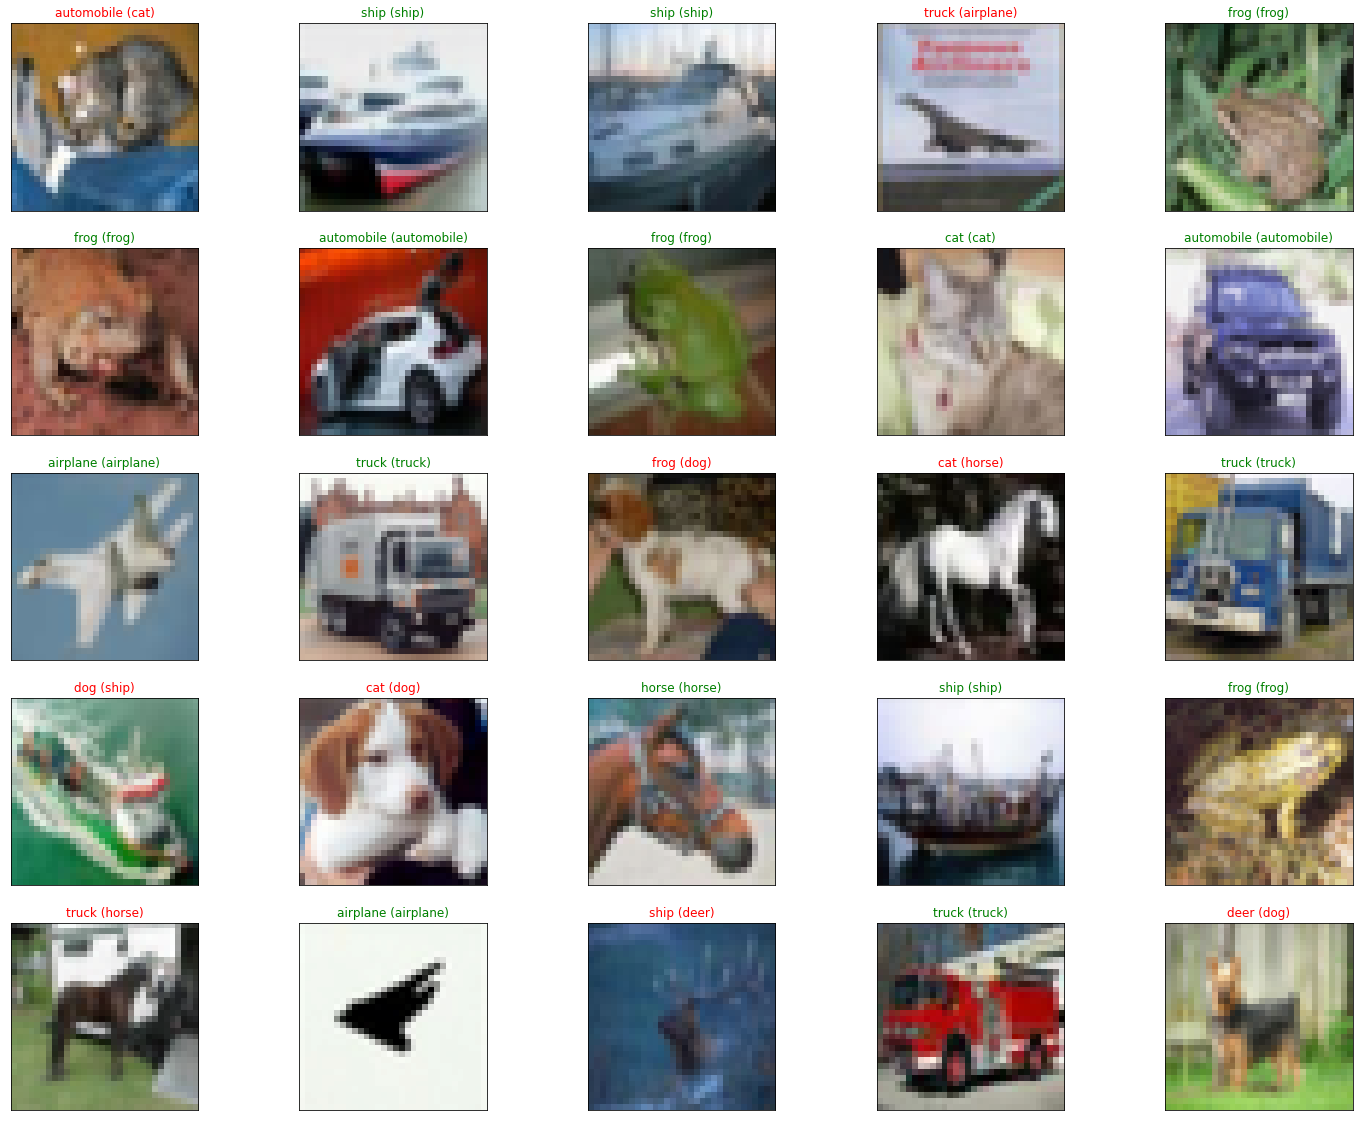

In [100]:
# obtain one batch of test images
images, labels = next(iter(test_loader))
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
# plot format: "predicted-label (true-label)"
fig = plt.figure(figsize=(25, 20))
for i in np.arange(25):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    image = np.squeeze(np.transpose(images[i], (1, 2, 0)))  # B*C*H*W --> H*W*C
    image = image * np.array((0.229, 0.224, 0.225)) + \
        np.array((0.485, 0.456, 0.406))  # un-normalize the image
    image = image.clip(0, 1)  # clip the values between 0 and 1
    ax.imshow(image)
    ax.set_title(f'{test_set.classes[test_stacked[i, 1].item()]} ({test_set.classes[labels[i].item()]})',
                color=('green' if test_stacked[i, 1]==labels[i] else 'red'))

plt.show()
fig.savefig(path_visu)
plt.close()

In [101]:
# calculate the confusion matrix for the train_set using train_stacked we calculated above
train_confmat = torch.zeros(10, 10, dtype=torch.int16)
for row in train_stacked:
    cl, pl = row.tolist()
    train_confmat[cl, pl] += 1

train_confmat

tensor([[3235,  239,  264,  144,  110,   32,   84,  164,  573,  155],
        [  86, 4124,   41,   84,   16,   36,   36,   41,  186,  350],
        [ 385,   92, 2545,  292,  508,  224,  591,  268,   84,   11],
        [ 101,  225,  240, 2485,  226,  876,  480,  199,   96,   72],
        [ 172,   38,  379,  257, 2735,  170,  508,  617,   92,   32],
        [  41,  126,  294,  732,  217, 2998,  179,  333,   49,   31],
        [  68,   85,  323,  334,  291,  181, 3623,   58,   32,    5],
        [ 111,  110,  241,  285,  391,  350,   72, 3302,   53,   85],
        [ 464,  338,   88,  100,   77,   31,   45,   25, 3580,  252],
        [ 154, 1231,   29,  137,   35,   28,   21,  123,  294, 2948]],
       dtype=torch.int16)

In [102]:
# calculate the confusion matrix for the test_set using test_stacked we calculated above
test_confmat = torch.zeros(10, 10, dtype=torch.int16)
for row in test_stacked:
    cl, pl = row.tolist()
    test_confmat[cl, pl] += 1

test_confmat

tensor([[633,  40,  47,  35,  26,   5,  13,  41, 128,  32],
        [ 19, 828,  10,  19,   1,   5,   2,   3,  50,  63],
        [ 84,  19, 458,  71, 118,  53, 130,  45,  20,   2],
        [ 22,  51,  62, 468,  41, 167, 105,  49,  22,  13],
        [ 26,  10,  91,  51, 539,  28, 127, 102,  23,   3],
        [ 15,  21,  51, 154,  36, 600,  38,  64,  15,   6],
        [ 19,  18,  59,  74,  58,  39, 705,  16,   9,   3],
        [ 22,  27,  59,  52,  74,  80,  19, 637,  15,  15],
        [ 90,  67,  21,  24,  17,   3,   8,   9, 711,  50],
        [ 32, 247,   7,  16,   4,   7,   3,  19,  77, 588]], dtype=torch.int16)

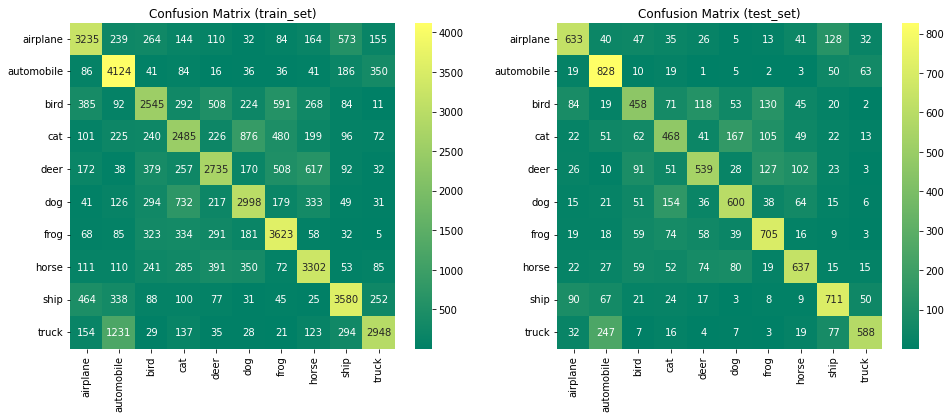

In [103]:
# plot confusion matrices
cm_train = pd.DataFrame(train_confmat.numpy(), index=train_set.classes, columns=train_set.classes)
cm_test = pd.DataFrame(test_confmat.numpy(), index=test_set.classes, columns=test_set.classes)

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax = sns.heatmap(cm_train, annot=True, cmap='summer', fmt='d', annot_kws={'size': 10})
ax.set_title("Confusion Matrix (train_set)")
ax = fig.add_subplot(122)
ax = sns.heatmap(cm_test, annot=True, cmap='summer', fmt='d', annot_kws={'size': 10})
ax.set_title("Confusion Matrix (test_set)")

plt.show()
fig.savefig(path_conf)
plt.close()

In [104]:
# print per-class train accuracy
for i in range(10):
    print('Train accuracy of {:12s}:\t{:.2f}% ({}/{})'.format(
        train_set.classes[i],
        100 * (train_confmat[i,i]/torch.as_tensor(train_set.targets).bincount()[i].item()),
        train_confmat[i,i],
        torch.as_tensor(train_set.targets).bincount()[i].item()
    ))

Train accuracy of airplane    :	64.70% (3235/5000)
Train accuracy of automobile  :	82.48% (4124/5000)
Train accuracy of bird        :	50.90% (2545/5000)
Train accuracy of cat         :	49.70% (2485/5000)
Train accuracy of deer        :	54.70% (2735/5000)
Train accuracy of dog         :	59.96% (2998/5000)
Train accuracy of frog        :	72.46% (3623/5000)
Train accuracy of horse       :	66.04% (3302/5000)
Train accuracy of ship        :	71.60% (3580/5000)
Train accuracy of truck       :	58.96% (2948/5000)


In [105]:
# print per-class test accuracy
for i in range(10):
    print('Test accuracy of {:12s}:\t{:.2f}% ({}/{})'.format(
        test_set.classes[i],
        100 * (test_confmat[i,i]/torch.as_tensor(test_set.targets).bincount()[i].item()),
        test_confmat[i,i],
        torch.as_tensor(test_set.targets).bincount()[i].item()
    ))

Test accuracy of airplane    :	63.30% (633/1000)
Test accuracy of automobile  :	82.80% (828/1000)
Test accuracy of bird        :	45.80% (458/1000)
Test accuracy of cat         :	46.80% (468/1000)
Test accuracy of deer        :	53.90% (539/1000)
Test accuracy of dog         :	60.00% (600/1000)
Test accuracy of frog        :	70.50% (705/1000)
Test accuracy of horse       :	63.70% (637/1000)
Test accuracy of ship        :	71.10% (711/1000)
Test accuracy of truck       :	58.80% (588/1000)


In [106]:
print('---- Raw Data ----')
print(f'[Train]:')
print(classification_report(train_stacked[:,0], train_stacked[:,1]))
print('[Test]:')
print(classification_report(test_stacked[:,0], test_stacked[:,1]))

---- Raw Data ----
[Train]:
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      5000
           1       0.62      0.82      0.71      5000
           2       0.57      0.51      0.54      5000
           3       0.51      0.50      0.50      5000
           4       0.59      0.55      0.57      5000
           5       0.61      0.60      0.60      5000
           6       0.64      0.72      0.68      5000
           7       0.64      0.66      0.65      5000
           8       0.71      0.72      0.71      5000
           9       0.75      0.59      0.66      5000

    accuracy                           0.63     50000
   macro avg       0.63      0.63      0.63     50000
weighted avg       0.63      0.63      0.63     50000

[Test]:
              precision    recall  f1-score   support

           0       0.66      0.63      0.65      1000
           1       0.62      0.83      0.71      1000
           2       0.53      0.46      0.4